This notebook demonstrates fitting a simple neural network to the residuals after calculating the height according to the ideal equations

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import torch
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Define the ideal equations

In [2]:
def pump_model_QH(Q,n):
    QH_coeff = [-0.580818, 1.65095, -1.4245, 0.105362, 0.104778, 0.249879]
    nref = .5
    QH_func = np.poly1d(QH_coeff)
    H = QH_func(Q)*(n/nref)**2
    return H

def pump_model_QP(Q,n):
    QP_coeff = [-0.263138, 0.0574016, 0.517813, 0.0929127]
    nref = .5
    QP_func = np.poly1d(QP_coeff)
    P = QP_func(Q)*(n/nref)**2
    return P

In [4]:
import torch
from torch.utils.data import Dataset 
import random

# Custom dataset. Data is returned with one pump being one item 
# Samples = [ Q, rpm ] and lables = [ H ]

class PumpData(Dataset):
    def __init__(self, directory):
        # get directory and list of csv files in directory 
        self.dir = directory                                        
        self.files = os.listdir(self.dir)
        self.csv_files = [f for f in self.files if (f.find(".csv") > 0)]
        self.num_pumps = len(self.csv_files)
        self.data = [[], []]
        # Create a random order to determine which pumps are for training/testing
        order = random.sample(range(0, 15), 15)

        # Load 12 pumps in random order for the training dataset 
        for n in range(12):
            d = np.genfromtxt(os.path.join(self.dir, self.csv_files[order[n]]), delimiter=",")
            d = np.delete(d, 0, axis=0)                             # delete header row which is text (nan)
            self.data[0].append(d)
        
        # Load the 3 other pumps in random order for the test dataset
        for n in range(12, self.num_pumps):
            d = np.genfromtxt(os.path.join(self.dir, self.csv_files[order[n]]), delimiter=",")
            d = np.delete(d, 0, axis=0)                             # delete header row which is text (nan) 
            self.data[1].append(d)

        self.data[0] = np.array(self.data[0])
        self.data[0] = self.data[0].reshape(-1, self.data[0].shape[-1]) # Combine pump data into one array
        self.data[1] = np.array(self.data[1])
        self.data[1] = self.data[1].reshape(-1, self.data[1].shape[-1])

    def __len__(self):
        return self.num_pumps                                       # length of the dataset = number of pumps 


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        samples = self.data[idx][:,[0,3]]                           # get column 0 and 3 (Q and rpm) as samples 
        labels = self.data[idx][:,1]                                # get labels from column 1 = H
        labels = labels - pump_model_QH(samples[:,0], samples[:,1]) # apply the ideal equations to make labels store the residual

        samples = torch.from_numpy(samples.astype(np.float32))      # convert from numpy array to pytorch tensor 
        labels = torch.from_numpy(labels.astype(np.float32)) 
        labels = labels.view(labels.shape[0], 1)                    # only one label size [n], but needs to be in [n, 1] 

        return samples, labels 

Visualizing the residuals

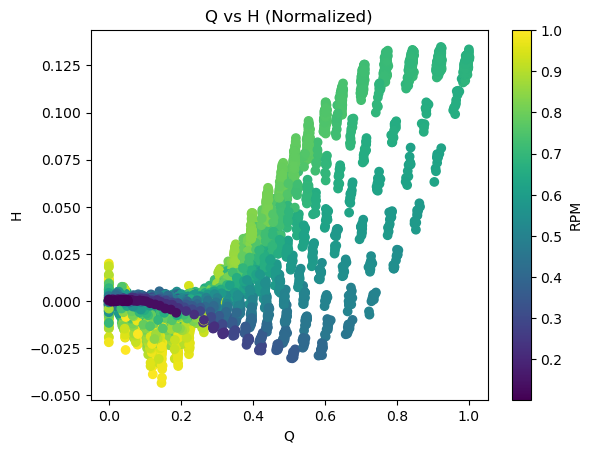

In [5]:
data_directory = os.path.join(os.getcwd(), "pump_data")

# Visualize Data 
i = 0


# Initialize the dataset, where pump_data[0] is the train set and pump_data[1] is the test set
pump_data =  PumpData(data_directory)

samples, labels = pump_data[i]

# Plot the training data
plt.scatter(samples[:,0], labels, c=samples[:,1])
plt.title('Q vs H (Normalized)')
plt.xlabel('Q')
plt.ylabel('H')
cbar = plt.colorbar()
cbar.set_label('RPM')
plt.show()

In [6]:
# define dataset and data loader 

train_dataset = pump_data[0]                                    # sample, labels 
samples, labels = train_dataset


n_samples, n_features = samples.shape
print("Samples:", n_samples, " --  Features:", n_features)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = 384, shuffle=True)

Samples: 6336  --  Features: 2


Define a simple neural network and train on the residuals

In [7]:
import torch.nn as nn

class CurveFit(nn.Module):
    def __init__(self, in_count, num_neurons, out_count):
        super(CurveFit, self).__init__()
        self.fc1 = nn.Linear(in_count, num_neurons)
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.fc3 = nn.Linear(num_neurons, out_count)
        self.relu = nn.LeakyReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)
    
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [27]:
model = CurveFit(2, 50, 1).to(device)


learning_rate = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 5000

for epoch in range(num_epochs):
    #for i, (samples, labels) in enumerate(train_dataset):

    samples, labels = train_dataset

    # push data to device (CPU or GPU)
    samples = samples.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(samples)
    loss = criterion(outputs, labels)

    # backward pass 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    if (epoch+1) % 100 == 0: 
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f} ')

epoch: 100, loss = 0.0005 
epoch: 200, loss = 0.0004 
epoch: 300, loss = 0.0004 
epoch: 400, loss = 0.0004 
epoch: 500, loss = 0.0003 
epoch: 600, loss = 0.0003 
epoch: 700, loss = 0.0003 
epoch: 800, loss = 0.0002 
epoch: 900, loss = 0.0002 
epoch: 1000, loss = 0.0002 
epoch: 1100, loss = 0.0002 
epoch: 1200, loss = 0.0002 
epoch: 1300, loss = 0.0002 
epoch: 1400, loss = 0.0002 
epoch: 1500, loss = 0.0002 
epoch: 1600, loss = 0.0002 
epoch: 1700, loss = 0.0002 
epoch: 1800, loss = 0.0002 
epoch: 1900, loss = 0.0002 
epoch: 2000, loss = 0.0002 
epoch: 2100, loss = 0.0002 
epoch: 2200, loss = 0.0002 
epoch: 2300, loss = 0.0001 
epoch: 2400, loss = 0.0001 
epoch: 2500, loss = 0.0001 
epoch: 2600, loss = 0.0001 
epoch: 2700, loss = 0.0001 
epoch: 2800, loss = 0.0001 
epoch: 2900, loss = 0.0001 
epoch: 3000, loss = 0.0001 
epoch: 3100, loss = 0.0001 
epoch: 3200, loss = 0.0001 
epoch: 3300, loss = 0.0001 
epoch: 3400, loss = 0.0001 
epoch: 3500, loss = 0.0001 
epoch: 3600, loss = 0.0001 
e

Testing the error rate we can see that training on the residuals of the ideal equations results in a better percent accuracy than training on the data alone

In [28]:
samples, labels = pump_data[1]

q = samples[:, [0]].numpy()
rpm = samples[:, [1]].numpy()

samples = samples.to(device)
labels = labels.to(device)

predicted = model(samples).detach()                    # detach so we dont train the model 
predicted = predicted.cpu().numpy()                     # move to cpu and convert tensor to numpy array 
predicted = predicted + pump_model_QH(q, rpm)

labels = labels.cpu().numpy() 
labels = labels + pump_model_QH(q, rpm) 

err = 0.0
n_samples = 528*3
error = np.empty(n_samples)
for n in range(n_samples):
    error[n] = abs(100 * (predicted[n].item() - labels[n].item()) / labels[n].item())
    err += abs(100 * (predicted[n].item() - labels[n].item()) / labels[n].item())
err = err/n_samples

print(f'Average error = {err:.4f}%')

Average error = 2.3374%


In [29]:
samples = samples.cpu().numpy()
q = samples[:, 0]
rpm = samples[:, 1]

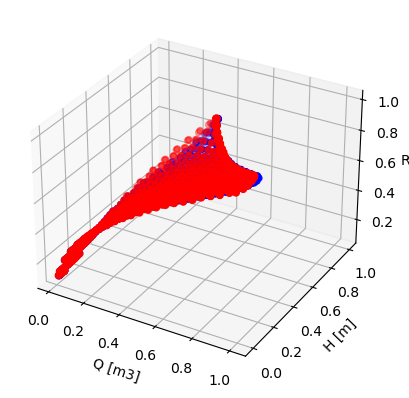

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(labels, q, rpm, zdir='z', c= 'red')
ax.scatter(predicted, q, rpm, zdir='z', c= 'b')
ax.set_xlabel('Q [m3]')
ax.set_ylabel('H [m]')
ax.set_zlabel('RPM')
plt.show()

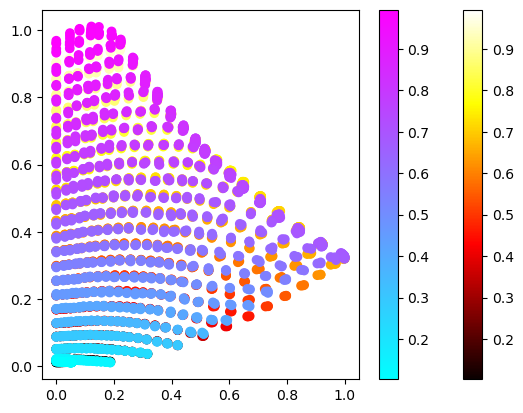

In [31]:
pa = plt.scatter(q, labels, c=rpm, cmap=plt.cm.hot)
plt.colorbar(pa)
pb = plt.scatter(q, predicted, c=rpm, cmap=plt.cm.cool)
plt.colorbar(pb)
plt.show()

You can attempt to fit a polynomial to the difference in the prediction of the model minus the actual value, but often this does not provide a better result

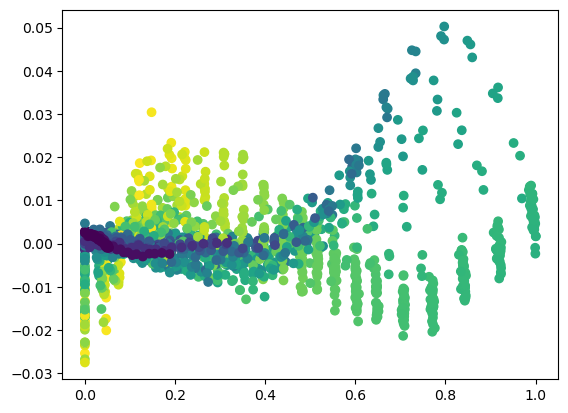

In [32]:
residual = predicted - labels
# Plot the residual based off q and rpm
# q vs residual w/ rpm as a colormap 
plt.scatter(q, residual, c=rpm)
plt.show()

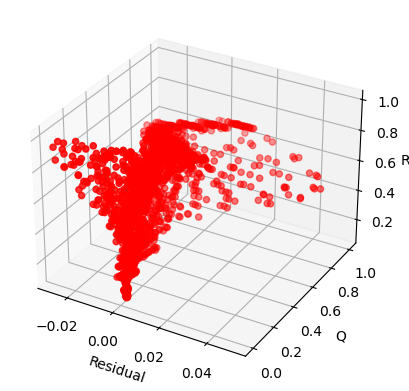

In [33]:
# 3d plot of residuals 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(residual, q, rpm, zdir='z', c= 'red')
ax.set_xlabel('Residual')
ax.set_ylabel('Q')
ax.set_zlabel('RPM')
plt.show()

In [34]:
from scipy.optimize import curve_fit

def func(xy, a, b, c, d, e, f):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x*y

In [35]:
q = q.flatten()
rpm = rpm.flatten()
residual = residual.flatten()

popt, pcov = curve_fit(func, (q, rpm), residual)
print(popt)

[ 0.00065864  0.05643041 -0.02690981  0.00263639  0.03367149 -0.08054845]


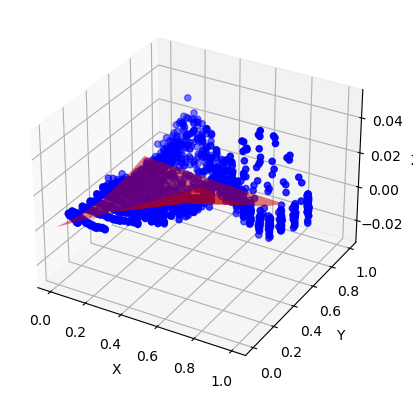

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(q, rpm, residual, c='blue')
x_range = np.arange(0, 1, .2)
y_range = np.arange(0, 1, .2)
X, Y = np.meshgrid(x_range, y_range)
Z = func((X, Y), *popt)
ax.plot_surface(X, Y, Z, color='red', alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [37]:
predicted = predicted.flatten()
# Get the new predictions based off the coefficients of the fitted curve
new_predictions = predicted + popt[0] + (popt[1] * q) + (popt[2] * rpm) + (popt[3] * q**2) + (popt[4] * rpm**2) + (popt[5] * q * rpm)
new_predictions

array([0.32796824, 0.3625537 , 0.406925  , ..., 0.0118216 , 0.01216235,
       0.01211265], dtype=float32)

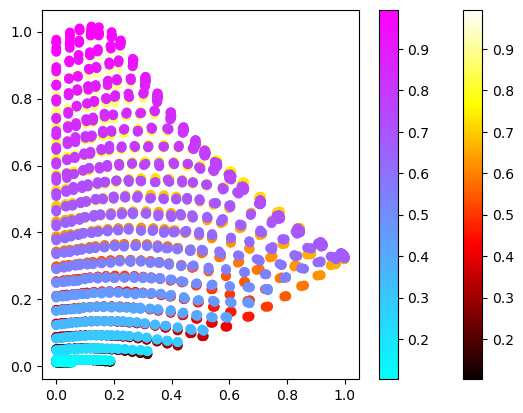

In [38]:
pa = plt.scatter(q, labels, c=rpm, cmap=plt.cm.hot)
plt.colorbar(pa)
pb = plt.scatter(q, new_predictions, c=rpm, cmap=plt.cm.cool)
plt.colorbar(pb)
plt.show()

In [39]:
# Test the error of the new predictions
err = 0.0 
n_sampels2 = 528*3
error = np.empty(n_sampels2)
for n in range(n_sampels2):
    error[n] = abs(100 * (new_predictions[n].item() - labels[n].item()) / labels[n].item())
    err += abs(100 * (new_predictions[n].item() - labels[n].item()) / labels[n].item())
err = err/n_sampels2

print(f'Average error = {err:.4f}%')

Average error = 2.6561%
